<a href="https://colab.research.google.com/github/ashraful005/DS_ML_Bootcamp/blob/master/Fish_Disease_Detection_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Install packages**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
!pip install torchmetrics
!pip install torchinfo

# **2. Import libraries**

In [4]:
# Data handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Preprocessing
import cv2
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# typing
from typing import Dict, List

# Counter
from collections import Counter

# random
import random

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (13).json


{'kaggle (13).json': b'{"username":"ashraful005","key":"4f746c27dab22414e17a0f5a0fe3baca"}'}

In [6]:
!pip install kaggle

In [7]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!cp kaggle.json ~/.kaggle

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
pip install --upgrade kaggle


In [11]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets list

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                                     Apple Quality                                      170KB  2024-01-11 14:31:07           5600        134  1.0              
hummaamqaasim/jobs-in-data                                         Jobs and Salaries in Data Science                   76KB  2023-12-25 20:03:32          11996        224  1.0              
computingvictor/zillow-market-analysis-and-real-estate-sales-data  🏠 Airbnb Market Analysis & Real Estate Sales Data    3MB  2024-01-26 16:29:34            828         31  1.0              
mrsimple07/obesity-prediction                     

In [13]:
!kaggle datasets download 'subirbiswas19/freshwater-fish-disease-aquaculture-in-south-asia'

freshwater-fish-disease-aquaculture-in-south-asia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
!unzip freshwater-fish-disease-aquaculture-in-south-asia.zip

Archive:  freshwater-fish-disease-aquaculture-in-south-asia.zip
replace SB-Fish-Disease.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [15]:
import pandas as pd

In [16]:
df=pd.read_csv('SB-Fish-Disease.csv')

In [17]:
df

Folder Name  \
0    Bacterial diseases - Aeromoniasis   
1    Bacterial diseases - Aeromoniasis   
2    Bacterial diseases - Aeromoniasis   
3    Bacterial diseases - Aeromoniasis   
4    Bacterial diseases - Aeromoniasis   
..                                 ...   
513  Viral diseases White tail disease   
514  Viral diseases White tail disease   
515  Viral diseases White tail disease   
516  Viral diseases White tail disease   
517  Viral diseases White tail disease   

                                 Image Filename  \
0    Bacterial diseases - Aeromoniasis (1).jpeg   
1     Bacterial diseases - Aeromoniasis (1).jpg   
2     Bacterial diseases - Aeromoniasis (1).png   
3    Bacterial diseases - Aeromoniasis (10).jpg   
4    Bacterial diseases - Aeromoniasis (11).jpg   
..                                          ...   
513   Viral diseases White tail disease (7).jpg   
514  Viral diseases White tail disease (8).jpeg   
515   Viral diseases White tail disease (8).jpg   
516  Viral diseases White tail disease (9).jpeg   
517   Viral diseases White tail disease (9).jpg   

                                            Image Path  
0    SB-FishDisease\Bacterial diseases - Aeromonias...  
1    SB-FishDisease\Bacterial diseases - Aeromonias...  
2    SB-FishDisease\Bacterial diseases - Aeromonias...  
3    SB-FishDisease\Bacterial diseases - Aeromonias...  
4    SB-FishDisease\Bacterial diseases - Aeromonias...  
..                                                 ...  
513  SB-FishDisease\Viral diseases White tail disea...  
514  SB-FishDisease\Viral diseases White tail disea...  
515  SB-FishDisease\Viral diseases White tail disea...  
516  SB-FishDisease\Viral diseases White tail disea...  
517  SB-FishDisease\Viral diseases White tail disea...  

[518 rows x 3 columns]

# **3. Load data and EDA**

In [18]:
# Let's see how many images we have.
from pathlib import Path
IMAGE_PATH = Path("/content/SB-FishDisease/SB-FishDisease")

image_path_list_jpg = list(IMAGE_PATH.glob("*/*.jpg"))
image_path_list_jpeg = list(IMAGE_PATH.glob("*/*.jpeg"))
image_path_list_png = list(IMAGE_PATH.glob("*/*.png"))
image_path_list_JPG = list(IMAGE_PATH.glob("*/*.JPG"))
image_path_list_webp = list(IMAGE_PATH.glob("*/*.webp"))

TOTAL_IMAGE_PATH_LIST = image_path_list_jpg + image_path_list_jpeg + image_path_list_png\
                        + image_path_list_JPG + image_path_list_webp

print(f'Total Images = {len(TOTAL_IMAGE_PATH_LIST)}')

Total Images = 460


In [19]:
# Let's visualize how many classes we have.
import os
classes = sorted(os.listdir(IMAGE_PATH))
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [20]:
# Let's see how many images per class we have.
from collections import Counter
class_count = []
for i in TOTAL_IMAGE_PATH_LIST:
    class_count.append(i.parent.stem)

Counter(class_count)

Counter({'Bacterial gill disease': 58,
         'Fungal diseases Saprolegniasis': 46,
         'Viral diseases White tail disease': 44,
         'Parasitic diseases': 38,
         'Healthy Fish': 177,
         'Bacterial Red disease': 48,
         'Bacterial diseases - Aeromoniasis': 49})

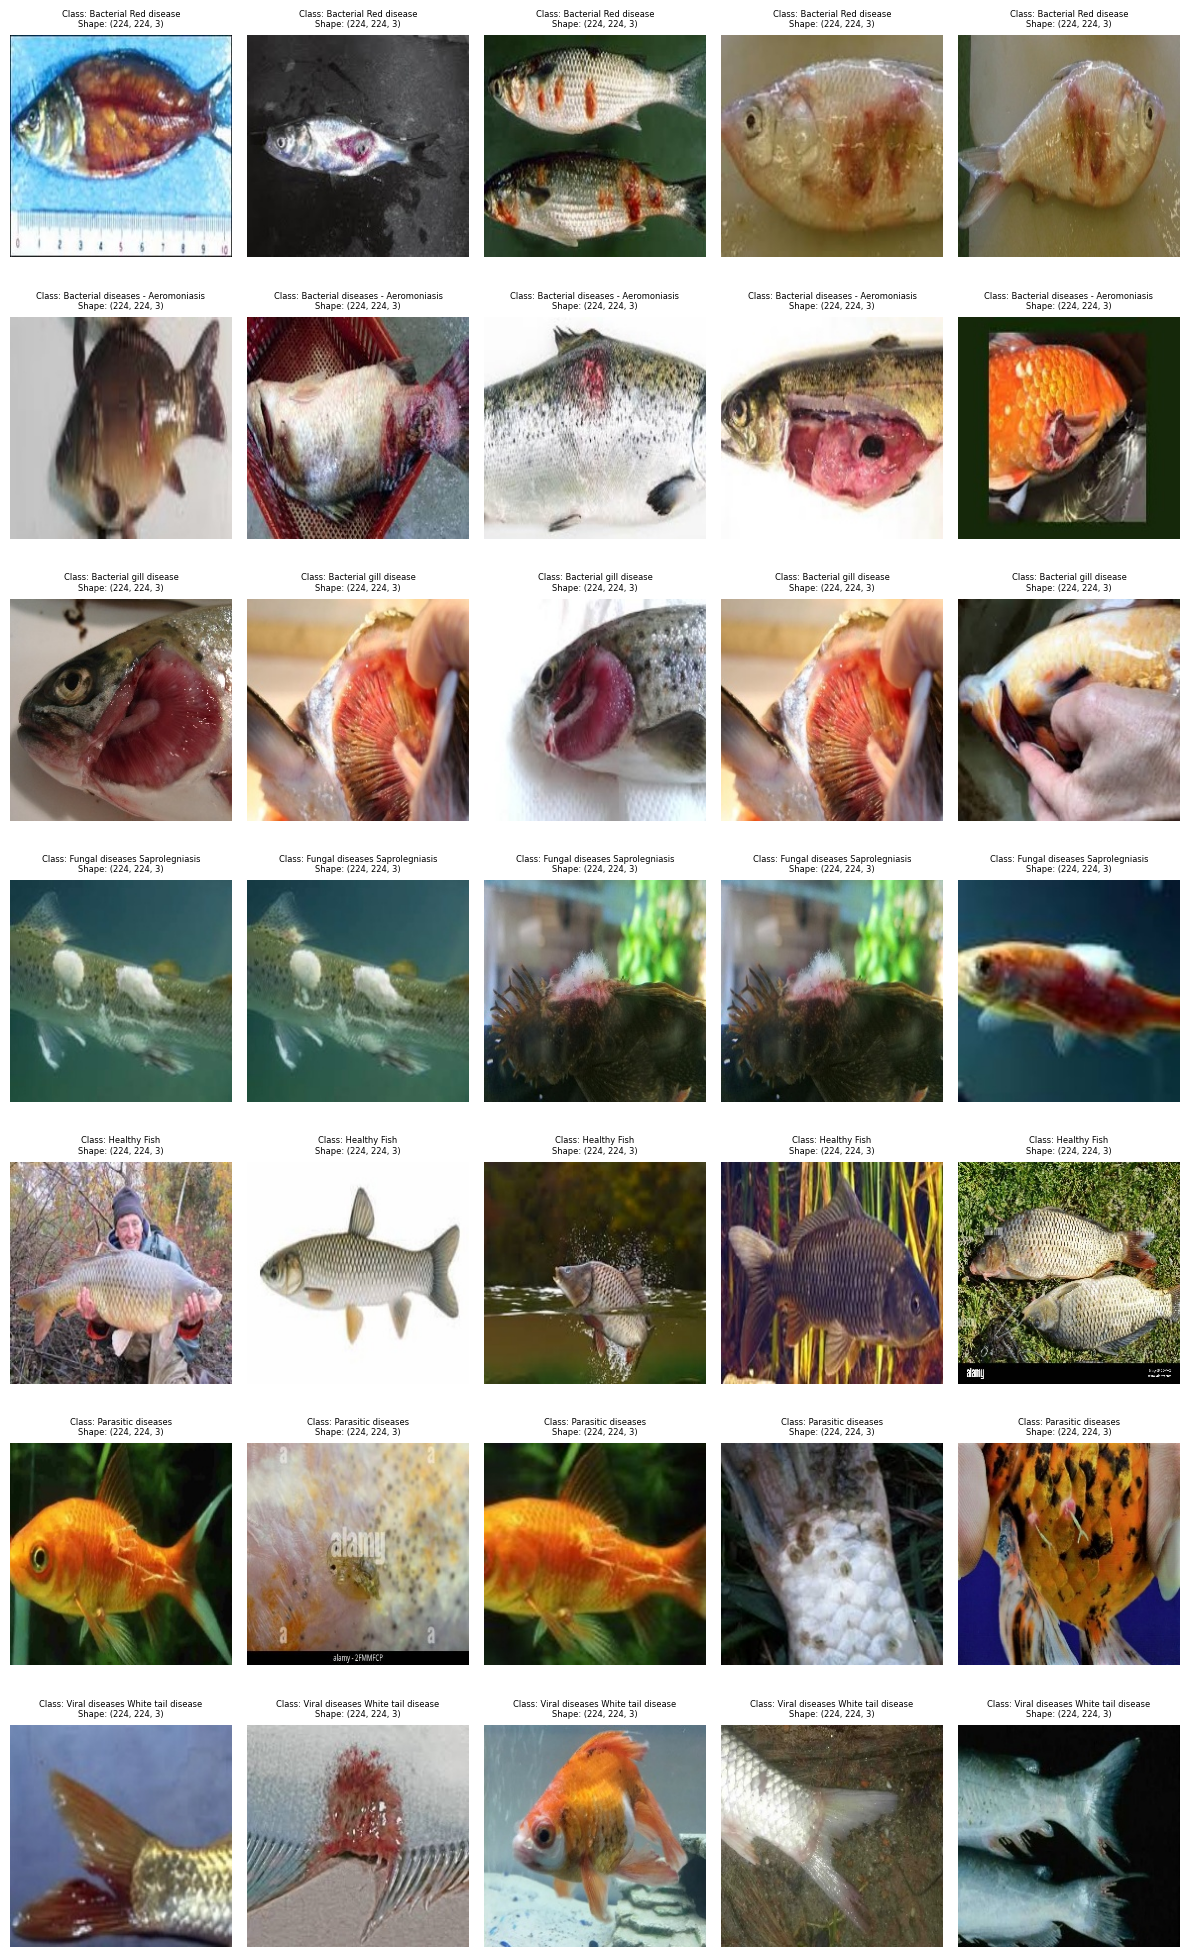

In [21]:
# Let's visualize 5 images for each class.
import matplotlib.pyplot as plt
import random
import cv2

fig,ax = plt.subplots(nrows = 7, ncols = 5, figsize = (12,20))
p = 0
for c in classes:

    a = random.choices(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")), k = 5)

    for i,j in enumerate(a):
        img_BGR = cv2.imread(str(j))
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_RGB)
        ax[p,i].set_title(f'Class: {j.parent.stem}\nShape: {img_RGB.shape}', fontsize = 6)
        ax[p,i].axis('off')
    p += 1

fig.tight_layout()
fig.show()

**We see that the images have different sizes, so we will proceed to see how the width and height of the images are distributed.**

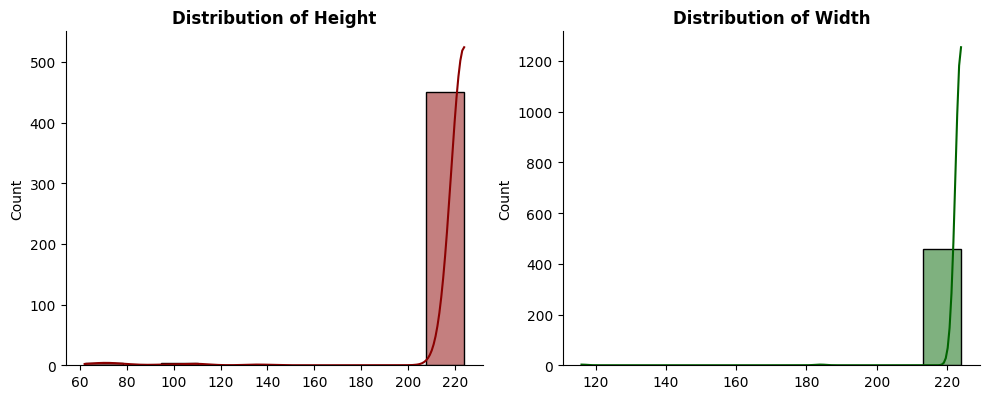

In [22]:
seq_height = []
seq_width = []

for i in TOTAL_IMAGE_PATH_LIST:
    img_BGR = cv2.imread(str(i))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    seq_height.append(img_RGB.shape[0])
    seq_width.append(img_RGB.shape[1])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.1))
ax = ax.flat

sns.histplot(seq_height, kde = True, color = 'darkred', ax = ax[0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Distribution of Height', fontweight = 'bold', color = 'black')

sns.histplot(seq_width, kde = True, color = 'darkgreen', ax = ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Distribution of Width', fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [23]:
df_height_width = pd.DataFrame({'height':seq_height, 'width':seq_width})

df_height_width.describe().T

count        mean        std    min    25%    50%    75%    max
height  460.0  221.345652  18.914556   62.0  224.0  224.0  224.0  224.0
width   460.0  223.678261   5.365991  116.0  224.0  224.0  224.0  224.0

# **4. Preprocessing**

In [24]:
# Let's create our pd.DataFrame to store the path of the images and their respective label.
img_path_and_label = {'img_path':[],
                      'label':[]}

for img_pth in TOTAL_IMAGE_PATH_LIST:
    img_path_and_label['img_path'].append(img_pth)
    img_path_and_label['label'].append(img_pth.parent.stem)

df_path_and_label = pd.DataFrame(img_path_and_label)
df_path_and_label.head()

img_path                   label
0  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial gill disease
1  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial gill disease
2  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial gill disease
3  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial gill disease
4  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial gill disease

In [25]:
# Now we are going to separate the paths of the images and their respective label.
X = df_path_and_label.drop('label', axis = 1)
y = df_path_and_label['label']

# Then, let's split into training and test set.
# But first we define the random seed for reproducibility.
SEED = 42

X_train, X_test, y_train, y_test = tts(X,y, test_size = 0.2, random_state = SEED, stratify = y)

In [26]:
print('Total Images of training set:')
print(Counter(y_train))
print('')

print('Total Images of test set:')
print(Counter(y_test))

Total Images of training set:
Counter({'Healthy Fish': 142, 'Bacterial gill disease': 46, 'Bacterial diseases - Aeromoniasis': 39, 'Bacterial Red disease': 39, 'Fungal diseases Saprolegniasis': 37, 'Viral diseases White tail disease': 35, 'Parasitic diseases': 30})

Total Images of test set:
Counter({'Healthy Fish': 35, 'Bacterial gill disease': 12, 'Bacterial diseases - Aeromoniasis': 10, 'Viral diseases White tail disease': 9, 'Fungal diseases Saprolegniasis': 9, 'Bacterial Red disease': 9, 'Parasitic diseases': 8})


In [27]:
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [28]:
# Now we have to convert our labels to number, where:
# Bacterial Red disease = 0
# Bacterial diseases - Aeromoniasis = 1
# Bacterial gill disease = 2
# Fungal diseases Saprolegniasis = 3
# Healthy Fish = 4
# Parasitic diseases = 5
# Viral diseases White tail disease = 6

label_map = dict(zip(classes, range(0,7)))

y_train_array = np.array(y_train.map(label_map))
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map))
y_test_torch = torch.from_numpy(y_test_array)
y_test_torch

tensor([4, 1, 2, 5, 4, 4, 1, 5, 6, 3, 4, 3, 4, 4, 0, 1, 4, 3, 6, 5, 0, 4, 3, 0,
        2, 2, 1, 5, 4, 6, 2, 6, 4, 1, 1, 4, 3, 2, 4, 4, 3, 1, 4, 4, 0, 0, 4, 4,
        5, 0, 2, 4, 2, 2, 4, 1, 6, 4, 4, 1, 4, 4, 3, 5, 0, 6, 3, 4, 6, 4, 4, 4,
        4, 2, 4, 2, 4, 5, 4, 3, 4, 1, 6, 0, 4, 6, 2, 4, 4, 5, 0, 2])

In [29]:
# We define the transformations for our data set.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [30]:
# We apply the transformations to our data sets.

images_train = [None] * len(X_train)

for i, (_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(img_path_train[0]).convert('RGB')
    images_train[i] = auto_transforms(img_train)

images_test = [None] * len(X_test)

for i, (_, img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(img_path_test[0]).convert('RGB')
    images_test[i] = auto_transforms(img_test)

In [31]:
# We will then convert our lists of tensors into a single tensor.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

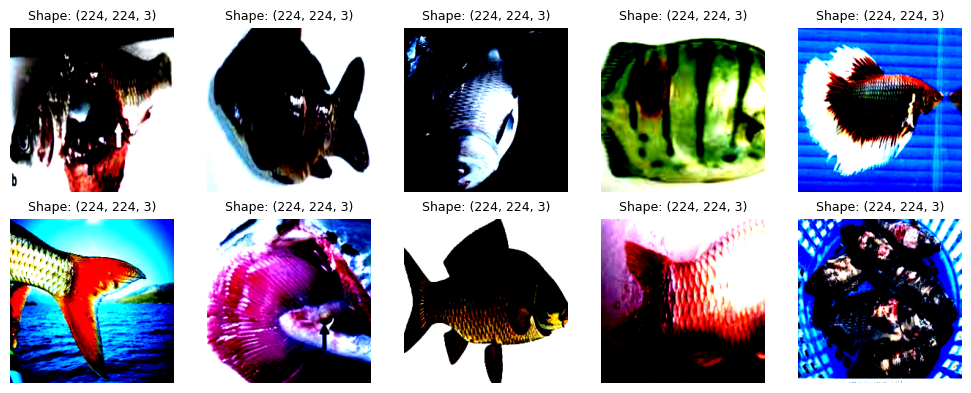

In [32]:
# Let's visualize some randomly selected transformed images.
indices = torch.randperm(10).numpy()

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4))
ax = ax.flat

for i,j in enumerate(indices):
    IMG = X_train_torch[j].permute(1,2,0).numpy()
    ax[i].imshow(IMG)
    ax[i].set_title(f'Shape: {IMG.shape}', fontsize = 9)
    ax[i].axis('off')

fig.tight_layout()
fig.show()

**Now we have to convert our tensors into Datase's and then convert it into DataLoader's.**

In [33]:
# First of all, we convert to Dataset but for this we have to create a Dataset class.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]

        return x,y





In [34]:
# Now we convert to Dataset.
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [35]:
# Then we convert to DataLoader.
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()



train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = True,
                             num_workers = NUM_WORKERS)

In [36]:
# prompt: code for data augmentation
from torchvision import transforms
from PIL import Image
# Let's define the transformations for our data set.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
])

test_transforms = auto_transforms
# We apply the transformations to our data sets.

images_train = []

for i, (_, img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(img_path_train[0]).convert('RGB')
    images_train.append(train_transforms(img_train))

images_test = [None] * len(X_test)

for i, (_, img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(img_path_test[0]).convert('RGB')
    images_test[i] = test_transforms(img_test)


In [37]:
# Let's visualize a batch.
images_batch, labels_batch = next(iter(test_dataloader))

images_batch.shape, labels_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

# **5. Model**

In [38]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [64]:
# We define the model to use.
#model = resnet50(weights = weights)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

# Define your ResNet-50 model
#model = resnet50(weights = weights)
model = models.resnet50(pretrained=True)
num_classes = 7  # Replace with your actual number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(model.fc.in_features, len(classes))
)

# Add data augmentation to your image transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [65]:
# Now we visualize the architecture of the model.
summary(model = model,
        input_size = [4,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 7]            --                True
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] 128               True
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   4,096             True
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   128               True

In [66]:
# Now we freeze the parameters of the extractor layers.
for param in model.parameters():
    param.requires_grad = False

In [67]:
# We go back to visualize how it looked after freezing the parameters.
# Now we visualize the architecture of the model.
summary(model = model,
        input_size = [4,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])


Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 7]            --                False
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] (128)             False
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   (4,096)           False
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   (128)           

In [68]:
# Let's visualize the last layer, which we will modify for our binary classification purpose.
model.fc

Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=2048, out_features=7, bias=True)
)

In [69]:
# We modify the last layer.
output_shape = len(classes)

model.fc = nn.Linear(in_features = 2048, out_features = output_shape, bias = True)

In [70]:
# We visualize our model again.
summary(model = model,
        input_size = [4,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 7]            --                Partial
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] (128)             False
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   (4,096)           False
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   (128)         

In [71]:
# Now let's visualize one step forward.

pred_logit = model(images_batch.to(device))
pred_logit

tensor([[ 0.0732,  0.4174,  0.0485, -0.3847,  0.3256, -0.5176, -0.4051],
        [-0.3215,  0.6136,  0.2490, -0.3308,  0.0960, -0.5677, -0.1514],
        [-0.1948,  0.6242,  0.4246, -0.3588,  0.2911, -0.2885,  0.3195],
        [-0.0082,  0.5613,  0.5768,  0.0237,  0.4041, -0.5546,  0.0202],
        [-0.0621,  0.4542,  0.1545, -0.1189,  0.2616, -0.4208, -0.1044],
        [-0.0268,  0.3444,  0.2724, -0.2133,  0.3660, -0.3463,  0.0619],
        [-0.1208,  0.8134,  0.2247,  0.0697,  0.7385, -0.3006,  0.0727],
        [-0.2602,  0.3793,  0.1433, -0.6366,  0.2062, -0.6014, -0.2865]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [72]:
# Let's define our loss function and the optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=.01)

**We are going to define 3 functions to execute the training**:

- train_step
- checkpoint
- test_step
- train

In [73]:

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):


    model.train()

    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes = len(classes), average = 'macro').to(device)

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = model(X)

        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        accuracy_train.update(y_pred_prob, y)

    train_loss = train_loss/len(dataloader)
    train_accuracy = accuracy_train.compute()
    accuracy_train.reset()

    return train_loss, train_accuracy

In [74]:
def save_checkpoint(filename, model, loss, epoch, optimizer):
    state = {'filename':filename,
             'model':model.state_dict(),
             'loss':loss,
             'epoch':epoch,
             'optimizer':optimizer.state_dict()}

    torch.save(state, filename)

In [75]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):


    model.eval()

    test_loss = 0.
    accuracy_test = MulticlassAccuracy(num_classes = len(classes), average = 'macro').to(device)

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)

            loss = loss_fn(y_pred_logit, y)
            test_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            accuracy_test.update(y_pred_prob, y)

    test_loss = test_loss/len(dataloader)
    test_accuracy = accuracy_test.compute()
    accuracy_test.reset()

    return test_loss, test_accuracy

In [76]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int):

    results = {'train_loss':[],
               'train_accuracy':[],
               'test_loss':[],
               'test_accuracy':[]}

    best_test_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                        dataloader = train_dataloader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer)


        test_loss, test_accuracy = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

        if test_loss < best_test_loss:
            best_test_loss = test_loss

            file_name = 'best_model.pt'

            save_checkpoint(file_name, model, best_test_loss, epoch, optimizer)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train Accuracy: {train_accuracy:.4f} | ',
              f'Test Loss: {test_loss:.4f} | ',
              f'Test Accuracy: {test_accuracy:.4f}')

        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)

    return results

In [ ]:
# Training !!

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
#from torch.optim import lr_scheduler

#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

EPOCHS = 150

MODEL_RESULTS = train(model.to(device),
                      train_dataloader,
                      test_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.6548 |  Train Accuracy: 0.2168 |  Test Loss: 1.2686 |  Test Accuracy: 0.3492
Epoch: 2 |  Train Loss: 1.1492 |  Train Accuracy: 0.4803 |  Test Loss: 1.1035 |  Test Accuracy: 0.5490
Epoch: 3 |  Train Loss: 1.0230 |  Train Accuracy: 0.5274 |  Test Loss: 0.9860 |  Test Accuracy: 0.6150
Epoch: 4 |  Train Loss: 0.8777 |  Train Accuracy: 0.5899 |  Test Loss: 0.8083 |  Test Accuracy: 0.6683
Epoch: 5 |  Train Loss: 0.7476 |  Train Accuracy: 0.7087 |  Test Loss: 0.9979 |  Test Accuracy: 0.6089
Epoch: 6 |  Train Loss: 0.7143 |  Train Accuracy: 0.6818 |  Test Loss: 0.7906 |  Test Accuracy: 0.6218
Epoch: 7 |  Train Loss: 0.6500 |  Train Accuracy: 0.7429 |  Test Loss: 0.8768 |  Test Accuracy: 0.6365
Epoch: 8 |  Train Loss: 0.6784 |  Train Accuracy: 0.7192 |  Test Loss: 0.7999 |  Test Accuracy: 0.6613
Epoch: 9 |  Train Loss: 0.5369 |  Train Accuracy: 0.7617 |  Test Loss: 0.7724 |  Test Accuracy: 0.6877
Epoch: 10 |  Train Loss: 0.5663 |  Train Accuracy: 0.8039 |  Test Loss: 0

In [ ]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

In [ ]:
plot_loss_metric_curve(MODEL_RESULTS)

In [ ]:
# We load the best model.
import torch
path_checkpoint = "/content/best_model.pt"
!ls {path_checkpoint}
#checkpoint = torch.load(path_checkpoint, map_location=torch.device('cpu'))
checkpoint = torch.load(path_checkpoint)

In [ ]:
# The best model gave us:

print(f'Best test loss = {checkpoint["loss"]}')
print(f'Epoch = {checkpoint["epoch"]+1}')

**Predictions**

In [ ]:
import torch
from torchvision import models

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)


model.to(device)
# Print the shapes of the parameters in the checkpoint
print(checkpoint["model"]["fc.weight"].shape)
print(checkpoint["model"]["fc.bias"].shape)

# Print the shapes of the parameters in the model
print(model.fc.weight.shape)
print(model.fc.bias.shape)

# Change the output dimension of the fc layer to 7
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(checkpoint["model"])


print(f"Model device: {next(model.parameters()).device}")
print(f"X_train_torch device: {X_train_torch.device}")

model.eval()

# Move the model to the appropriate device
model = model.to('cuda:0')

# Move the input tensors to the same device as the model
X_train_torch = X_train_torch.to('cuda:0')
X_test_torch = X_test_torch.to('cuda:0')

with torch.no_grad():
    y_pred_logits_train = model(X_train_torch)
    y_pred_logits_test = model(X_test_torch)



In [ ]:
y_pred_prob_train = torch.softmax(y_pred_logits_train, dim = 1).cpu()
y_pred_class_train = torch.argmax(y_pred_prob_train, dim = 1).numpy().astype(int)

y_pred_prob_test = torch.softmax(y_pred_logits_test, dim = 1).cpu()
y_pred_class_test = torch.argmax(y_pred_prob_test, dim = 1).numpy().astype(int)

# **6. Metrics**

**Confusion Matrix**

In [ ]:
cf_mx_train = confusion_matrix(y_train_array.astype(int), y_pred_class_train)
cf_mx_test = confusion_matrix(y_test_array.astype(int), y_pred_class_test)

In [ ]:
# Confusion Matrix Plot
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax = ax.flat
sns.heatmap(cf_mx_train,
            cmap = 'Blues',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')

sns.heatmap(cf_mx_test,
            cmap = 'Reds',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

**Accuray score**

In [ ]:
print(f'Accuracy train = {accuracy_score(y_train_array.astype(int), y_pred_class_train)}')

print(f'Accuracy test = {accuracy_score(y_test_array.astype(int), y_pred_class_test)}')

**Classification Report**

In [ ]:
# To perform a reverse mapping, go from id to label.
id2label = dict(zip(range(0,7),classes))
id2label

In [ ]:
print("=="*40)
print(" " * 25, "Classification Report Train")
print("=="*40)
print(classification_report(pd.Series(y_train_array).map(id2label),
                            pd.Series(y_pred_class_train).map(id2label),))

print("=="*40)
print(" " * 25, "Classification Report Test")
print("=="*40)
print(classification_report(pd.Series(y_test_array).map(id2label),
                            pd.Series(y_pred_class_test).map(id2label)))